In [1]:
# Orignial Notebook: https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
# This notebook author: Reza Chu
# Last Editing Date: 31st May 2019

## Python
import os
import random
import sys

import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)

## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#load video name train and test
import joblib
audio_test = joblib.load('/content/drive/My Drive/fusion/video/video_name/video_name_test_1')
audio_train = joblib.load('/content/drive/My Drive/fusion/video/video_name/video_name_train_1')

In [33]:
y_test = joblib.load('/content/drive/My Drive/fusion/video/data_set_fusion/expert1/labels_test')
labels_train = joblib.load('/content/drive/My Drive/fusion/video/data_set_fusion/expert1/labels_train')

In [47]:
len(audio_test),len(audio_train)

(207, 1860)

In [7]:
audio_test

['/content/drive/MyDrive/frames_ravdess_label/neutral/01-02-01-01-02-01-10.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/sad/01-02-04-02-01-02-22.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/happy/01-01-03-02-02-01-18.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/fearful/01-01-06-01-02-02-23.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/fearful/01-02-06-01-02-02-10.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/happy/01-01-03-01-02-02-04.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/fearful/01-01-06-02-01-02-20.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/calm/01-01-02-02-02-01-15.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/angry/01-01-05-01-01-02-17.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/neutral/01-02-01-01-02-02-06.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/sad/01-01-04-02-02-02-06.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/calm/01-01-02-01-02-02-24.mp4',
 '/content/drive/MyDrive/frames_ravdess_label/an

In [27]:
test=[]

for i in audio_test:
  s=i.split('/')[6]
  s=s.split('-')
  s[0]='03'
  s[6]=s[6].split('.')[0]
  if(s[1]=='01'):
    kind='speech'
  else:
    kind='song'
  actor=s[-1]
  listToStr = '-'.join(map(str, s))
  listToStr+=".wav"
  path='/content/drive/My Drive/data_set/RAVDESS_'+kind+'/Actor_'+s[-1]+'/'+listToStr
  test.append(path)

In [28]:
test

['/content/drive/My Drive/data_set/RAVDESS_song/Actor_10/03-02-01-01-02-01-10.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_22/03-02-04-02-01-02-22.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_18/03-01-03-02-02-01-18.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_23/03-01-06-01-02-02-23.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_10/03-02-06-01-02-02-10.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_04/03-01-03-01-02-02-04.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_20/03-01-06-02-01-02-20.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_15/03-01-02-02-02-01-15.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_17/03-01-05-01-01-02-17.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_06/03-02-01-01-02-02-06.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_06/03-01-04-02-02-02-06.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_24/03-

In [29]:
train=[]

for i in audio_train:
  s=i.split('/')[6]
  s=s.split('-')
  s[0]='03'
  s[6]=s[6].split('.')[0]
  if(s[1]=='01'):
    kind='speech'
  else:
    kind='song'
  actor=s[-1]
  listToStr = '-'.join(map(str, s))
  listToStr+=".wav"
  path='/content/drive/My Drive/data_set/RAVDESS_'+kind+'/Actor_'+s[-1]+'/'+listToStr
  train.append(path)

In [30]:
train

['/content/drive/My Drive/data_set/RAVDESS_song/Actor_12/03-02-03-01-02-02-12.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_11/03-01-01-01-02-02-11.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_13/03-02-02-01-02-01-13.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_06/03-01-02-01-01-02-06.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_05/03-02-05-02-01-01-05.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_11/03-02-03-02-02-02-11.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_03/03-02-05-02-02-01-03.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_06/03-01-02-01-02-02-06.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_07/03-02-03-02-01-02-07.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_22/03-02-05-02-01-02-22.wav',
 '/content/drive/My Drive/data_set/RAVDESS_speech/Actor_23/03-01-04-01-02-02-23.wav',
 '/content/drive/My Drive/data_set/RAVDESS_song/Actor_04/03-02-03-01

In [37]:
len(train)

1860

In [39]:
from sklearn.model_selection import train_test_split
x_valid, signal_train, y_valid, label_test = train_test_split(train,labels_train, test_size=0.9,train_size=0.1, random_state=42)
len(signal_train),len(x_valid)
    #,x_valid.shape,label_test.shape,y_valid

(1674, 186)

In [42]:
len(y_valid),len(label_test)

(186, 1674)

In [ ]:
"""
Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
"""

In [41]:
#radvass speech and song
import time
import os
import librosa
from librosa import display
import matplotlib.pyplot as plt

count=0
x_test = []
X_valid=[]
start_time = time.time()

for path in x_valid :
      try:
        count +=1
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        #emo = int(file[7:8]) - 1 
        #arr = X, emo
        X_valid.append(mfccs)
      # If the file is not valid, skip it
      except ValueError:
        continue

for path in test :
      try:
        count +=1
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        #emo = int(file[7:8]) - 1 
        #arr = X, emo
        x_test.append(mfccs)
      # If the file is not valid, skip it
      except ValueError:
        continue
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))


--- Data loaded. Loading time: 94.60594725608826 seconds ---


In [46]:
X_valid=np.asarray(X_valid)
x_test=np.asarray(x_test)
X_valid.shape,x_test.shape

((186, 40), (207, 40))

In [48]:
train_lst=[]
for i in range(len(signal_train)):
  X, sample_rate = librosa.load(signal_train[i], res_type='kaiser_fast')
  emo=label_test[i]
  x=X
  arr=x,emo
  train_lst.append(arr)
  x=librosa.effects.time_stretch(X,0.5)
  arr=x,emo
  train_lst.append(arr)
  x=librosa.effects.time_stretch(X,1.5)
  arr=x,emo
  train_lst.append(arr)
  x=librosa.effects.pitch_shift(X,sample_rate,2)
  arr=x,emo
  train_lst.append(arr)

In [49]:
x_train, y_train = zip(*train_lst)

In [50]:
x_train=np.asarray(x_train)
y_train=np.asarray(y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [51]:
y_train.shape

(6696,)

In [52]:
X_train=[]
for i in range(x_train.size):
  X_train.append(np.mean(librosa.feature.mfcc(y=x_train[i], sr=sample_rate, n_mfcc=40).T,axis=0))

In [53]:
X_train=np.asarray(X_train)
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,x_test.shape,y_test.shape

((6696, 40), (6696,), (186, 40), (186,), (207, 40), (207,))

In [54]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from keras.models import InputLayer

model = Sequential(InputLayer((40,1)))
model.add(BatchNormalization())

model.add(Conv1D(128, 12,padding='same', ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(5)))


model.add(Conv1D(256,12,padding='same',))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(lr=0.0002)
#opt = tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-07, decay=0.0)
#opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 40, 1)            4         
 hNormalization)                                                 
                                                                 
 conv1d_8 (Conv1D)           (None, 40, 128)           1664      
                                                                 
 batch_normalization_7 (Batc  (None, 40, 128)          512       
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (None, 40, 128)           0         
                                                                 
 dropout_8 (Dropout)         (None, 40, 128)           0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 8, 128)          

In [55]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [56]:
#X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,x_test.shape,y_test.shape
cnnhistory=model.fit(X_train, y_train, batch_size=16, epochs=400,validation_data=(X_valid, y_valid))

Epoch 1/400
419/419 [==============================] - 15s 31ms/step - loss: 1.7293 - accuracy: 0.3109 - val_loss: 2.6281 - val_accuracy: 0.1720
Epoch 2/400
419/419 [==============================] - 19s 45ms/step - loss: 1.5056 - accuracy: 0.3832 - val_loss: 1.4492 - val_accuracy: 0.4086
Epoch 3/400
419/419 [==============================] - 17s 40ms/step - loss: 1.4003 - accuracy: 0.4301 - val_loss: 1.3374 - val_accuracy: 0.4677
Epoch 4/400
419/419 [==============================] - 16s 37ms/step - loss: 1.3209 - accuracy: 0.4671 - val_loss: 1.4648 - val_accuracy: 0.3710
Epoch 5/400
419/419 [==============================] - 13s 30ms/step - loss: 1.2400 - accuracy: 0.5000 - val_loss: 1.1424 - val_accuracy: 0.5806
Epoch 6/400
419/419 [==============================] - 12s 29ms/step - loss: 1.1732 - accuracy: 0.5243 - val_loss: 1.3543 - val_accuracy: 0.3871
Epoch 7/400
419/419 [==============================] - 13s 31ms/step - loss: 1.1138 - accuracy: 0.5627 - val_loss: 1.1470 - val_ac

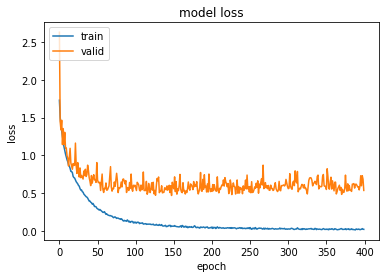

In [57]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

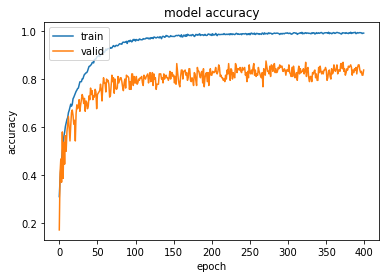

In [58]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [59]:
#predictions = model.predict_classes(x_testcnn)
predictions = model.predict(x_test)
predictions

array([[1.0000000e+00, 7.9228751e-14, 1.0684086e-14, 1.0458018e-09,
        3.3211510e-08, 1.3556589e-10],
       [8.4953871e-17, 2.0549409e-15, 1.3010764e-17, 9.9998653e-01,
        3.1759994e-15, 1.3430396e-05],
       [5.9611135e-11, 1.2920171e-11, 9.7966731e-01, 9.3361638e-07,
        1.0621551e-09, 2.0331804e-02],
       ...,
       [1.4766292e-06, 1.5178329e-05, 4.4325649e-04, 4.3973494e-03,
        9.6278644e-01, 3.2356210e-02],
       [2.1887956e-15, 2.9276047e-14, 6.6686938e-12, 2.1182028e-15,
        9.9999964e-01, 3.7927944e-07],
       [2.1587253e-16, 9.9192142e-01, 1.8200420e-09, 8.0785351e-03,
        3.9072430e-18, 3.8228326e-13]], dtype=float32)

In [60]:

df_audio_test = pd.DataFrame(predictions,columns=["OA_"+str(i) for i in range(6)])


In [61]:
y_test

array([0, 3, 2, 5, 5, 2, 5, 1, 4, 0, 3, 1, 4, 0, 4, 3, 4, 1, 1, 1, 5, 2,
       0, 2, 2, 5, 3, 5, 5, 5, 5, 4, 5, 0, 2, 2, 4, 1, 5, 4, 2, 2, 1, 5,
       2, 1, 5, 5, 4, 3, 4, 2, 1, 3, 3, 0, 0, 0, 2, 5, 4, 4, 5, 3, 1, 3,
       1, 0, 5, 1, 1, 2, 5, 5, 5, 4, 0, 3, 4, 4, 3, 4, 4, 0, 0, 1, 2, 3,
       3, 5, 5, 1, 0, 1, 5, 5, 1, 2, 5, 3, 4, 3, 3, 5, 4, 3, 2, 1, 4, 1,
       5, 2, 0, 1, 4, 0, 4, 1, 1, 1, 1, 5, 1, 4, 1, 2, 3, 2, 5, 1, 2, 0,
       1, 5, 1, 0, 5, 0, 2, 1, 2, 1, 2, 3, 1, 2, 3, 0, 0, 3, 2, 3, 5, 3,
       1, 2, 1, 3, 0, 0, 1, 3, 3, 2, 4, 1, 0, 0, 5, 4, 4, 3, 1, 4, 3, 1,
       5, 0, 4, 5, 4, 0, 0, 5, 3, 3, 1, 3, 3, 4, 1, 4, 1, 1, 4, 2, 3, 1,
       4, 5, 3, 2, 5, 2, 4, 4, 1])

In [62]:
new_Ytest = y_test.astype(int)
new_Ytest

array([0, 3, 2, 5, 5, 2, 5, 1, 4, 0, 3, 1, 4, 0, 4, 3, 4, 1, 1, 1, 5, 2,
       0, 2, 2, 5, 3, 5, 5, 5, 5, 4, 5, 0, 2, 2, 4, 1, 5, 4, 2, 2, 1, 5,
       2, 1, 5, 5, 4, 3, 4, 2, 1, 3, 3, 0, 0, 0, 2, 5, 4, 4, 5, 3, 1, 3,
       1, 0, 5, 1, 1, 2, 5, 5, 5, 4, 0, 3, 4, 4, 3, 4, 4, 0, 0, 1, 2, 3,
       3, 5, 5, 1, 0, 1, 5, 5, 1, 2, 5, 3, 4, 3, 3, 5, 4, 3, 2, 1, 4, 1,
       5, 2, 0, 1, 4, 0, 4, 1, 1, 1, 1, 5, 1, 4, 1, 2, 3, 2, 5, 1, 2, 0,
       1, 5, 1, 0, 5, 0, 2, 1, 2, 1, 2, 3, 1, 2, 3, 0, 0, 3, 2, 3, 5, 3,
       1, 2, 1, 3, 0, 0, 1, 3, 3, 2, 4, 1, 0, 0, 5, 4, 4, 3, 1, 4, 3, 1,
       5, 0, 4, 5, 4, 0, 0, 5, 3, 3, 1, 3, 3, 4, 1, 4, 1, 1, 4, 2, 3, 1,
       4, 5, 3, 2, 5, 2, 4, 4, 1])

In [63]:
preds1=predictions.argmax(axis=1)
preds1

array([0, 3, 2, 5, 3, 2, 5, 1, 4, 0, 3, 3, 4, 0, 0, 3, 4, 1, 1, 1, 5, 2,
       0, 2, 1, 5, 3, 5, 5, 5, 3, 4, 5, 3, 2, 2, 4, 1, 5, 4, 2, 2, 2, 5,
       2, 1, 5, 5, 4, 3, 4, 2, 1, 3, 3, 0, 0, 0, 2, 4, 4, 4, 5, 3, 1, 3,
       1, 3, 3, 1, 4, 2, 3, 3, 5, 4, 0, 3, 4, 5, 3, 4, 4, 0, 0, 1, 2, 1,
       3, 5, 5, 1, 0, 1, 5, 5, 1, 4, 4, 1, 4, 3, 3, 5, 4, 5, 4, 1, 4, 1,
       5, 2, 0, 2, 4, 0, 4, 1, 1, 1, 1, 5, 1, 4, 1, 2, 3, 2, 5, 1, 2, 2,
       1, 5, 1, 0, 5, 0, 2, 1, 2, 1, 2, 3, 1, 2, 3, 0, 0, 3, 2, 3, 5, 3,
       1, 2, 0, 3, 3, 0, 1, 3, 3, 2, 4, 1, 1, 0, 5, 4, 4, 3, 1, 4, 3, 1,
       3, 0, 4, 4, 4, 0, 0, 5, 3, 3, 1, 3, 3, 4, 1, 4, 1, 1, 4, 2, 3, 1,
       4, 5, 2, 5, 5, 2, 4, 4, 1])

In [64]:
abc = preds1.astype(int).flatten()
from sklearn.metrics import confusion_matrix
c = confusion_matrix(new_Ytest, abc) 
c

array([[22,  1,  1,  3,  0,  0],
       [ 1, 39,  2,  1,  1,  0],
       [ 0,  1, 26,  0,  2,  1],
       [ 0,  2,  1, 30,  0,  1],
       [ 1,  0,  0,  0, 32,  1],
       [ 0,  0,  0,  6,  3, 29]])

In [65]:
model.save('/content/drive/My Drive/fusion/audio/model/expert1')
print("MODEL SAVED")

INFO:tensorflow:Assets written to: /content/drive/My Drive/fusion/audio/model/expert1/assets
MODEL SAVED


In [66]:
new_model=keras.models.load_model('/content/drive/My Drive/fusion/audio/model/expert1')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 40, 1)            4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 40, 128)           1664      
                                                                 
 batch_normalization_1 (Batc  (None, 40, 128)          512       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 40, 128)           0         
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 128)           0

In [67]:
loss, acc = new_model.evaluate(x_test, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

7/7 [==============================] - 0s 8ms/step - loss: 0.6044 - accuracy: 0.8599
Restored model, accuracy: 85.99%


              precision    recall  f1-score   support

           0       0.92      0.81      0.86        27
           1       0.91      0.89      0.90        44
           2       0.87      0.87      0.87        30
           3       0.75      0.88      0.81        34
           4       0.84      0.94      0.89        34
           5       0.91      0.76      0.83        38

    accuracy                           0.86       207
   macro avg       0.86      0.86      0.86       207
weighted avg       0.87      0.86      0.86       207

----accuracy score 85.99033816425121 ----


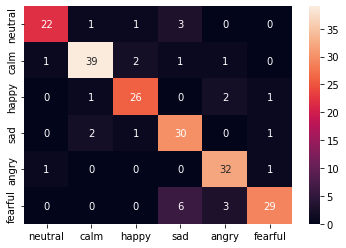

In [68]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(y_test,abc))

acc = float(accuracy_score(y_test,abc))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,abc)
#df_cm = pd.DataFrame(cm)
class_names = ['neutral','calm', 'happy','sad','angry', 'fearful' ]
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names,)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [69]:
count=0
new_x_train=[]
for path in train :
      try:
        count +=1
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        #emo = int(file[7:8]) - 1 
        #arr = X, emo
        new_x_train.append(mfccs)
      # If the file is not valid, skip it
      except ValueError:
        continue
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 7549.768930673599 seconds ---


In [74]:
new_x_train=np.asarray(new_x_train)
prediction = new_model.predict(new_x_train)
prediction

array([[1.3270062e-21, 3.8416599e-09, 1.0000000e+00, 3.6645697e-13,
        3.5219860e-16, 3.5346962e-21],
       [9.9925834e-01, 6.8750262e-04, 2.4363160e-05, 2.9324563e-05,
        2.1029262e-08, 4.1960888e-07],
       [6.6084846e-15, 9.9999154e-01, 8.4786743e-06, 5.9662388e-15,
        2.6776069e-15, 8.2205428e-13],
       ...,
       [1.2328722e-07, 5.0174510e-08, 2.0111374e-04, 1.6918266e-04,
        9.9840063e-01, 1.2288169e-03],
       [3.2711914e-13, 1.4573013e-11, 9.9967706e-01, 1.9086146e-06,
        3.2110212e-04, 2.9316471e-08],
       [2.7710828e-04, 1.0795898e-05, 3.2329613e-06, 9.9855310e-01,
        9.3081808e-06, 1.1464249e-03]], dtype=float32)

In [75]:
df_audio_train = pd.DataFrame(prediction,columns=["OA_"+str(i) for i in range(6)])

In [76]:
pred=prediction.argmax(axis=1)
pred=prediction.astype(int).flatten()

In [77]:
import joblib

save_dir = '/content/drive/My Drive/fusion/audio/data_set_fusion/expert1'

savedvX = joblib.dump(abc, os.path.join(save_dir, 'predict_test'))
savedvX = joblib.dump(predictions, os.path.join(save_dir, 'x_test'))
savedvX = joblib.dump(prediction, os.path.join(save_dir, 'x_train'))
savedvX = joblib.dump(pred, os.path.join(save_dir, 'predict_train'))